## Retinal vessel detection

In [51]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, clear_output
from skimage.filters import frangi
from skimage.morphology import remove_small_objects
from skimage.util import img_as_bool
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import pickle
from imblearn.under_sampling import RandomUnderSampler
import random


In [24]:
def load_image(file_name):
    base_name = os.path.splitext(file_name)[0]

    img_path = os.path.join("./HRF/healthy", base_name + ".jpg")
    img = cv2.imread(img_path)

    manual_path = os.path.join("./HRF/healthy_manualsegm", base_name + ".tif")
    manual = cv2.imread(manual_path, 0)
    
    fov_path = os.path.join("./HRF/healthy_fovmask", base_name + "_mask.tif")
    fov = cv2.imread(fov_path, 0)

    return img, manual // 255, fov // 255

### 1. Image processing

In [3]:
def preprocessing(image):
    green_image = image[:,:,1]
    denoised_image = cv2.medianBlur(green_image, 5)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    eqaualized_image = clahe.apply(denoised_image)

    return eqaualized_image

In [4]:
def image_processing(image, fov_mask):
    preprocessed_image = preprocessing(image)

    frangi_image = frangi(preprocessed_image)
    
    fov_bin = (fov_mask > 0).astype(np.uint8)
    frangi_image = frangi_image * fov_bin

    normalized_frangi_image = cv2.normalize(frangi_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    binary_vessels = normalized_frangi_image.copy()
    binary_vessels[binary_vessels > 0] = 255  # binary mask

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened_img = cv2.morphologyEx(binary_vessels, cv2.MORPH_OPEN, kernel, iterations=2)
    
    dilated_img = cv2.dilate(opened_img, kernel, iterations=3)

    bool_dilated = img_as_bool(dilated_img)
    cleaned_dilated = remove_small_objects(bool_dilated, min_size=1000)
    final_img = (cleaned_dilated * 255).astype(np.uint8)

    return final_img


In [ ]:
def show_results(image, vessels_mask, manual):
    bgr_image = image.copy()
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    rgb_image[vessels_mask > 0] = [0, 0, 255]
    
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title("Ground truth (manual mask)")
    plt.imshow(manual, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Detected vessels")
    plt.imshow(vessels_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Visualization of vessel detection")
    plt.imshow(rgb_image, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_detection(manual_mask, detected_mask, fov):
    mask = fov > 0
    y_true = manual_mask[mask].flatten()
    y_pred = (detected_mask[mask] > 0).astype(np.uint8).flatten()

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    arithmetic_mean = (sensitivity + specificity) / 2
    geometric_mean = np.sqrt(sensitivity * specificity)

    print(f"accuracy: {accuracy:.4f}, sensitivity: {sensitivity:.4f}, specificity: {specificity:.4f}, arithmetic mean: {arithmetic_mean:.4f}, geometric mean: {geometric_mean:.4f}")

    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

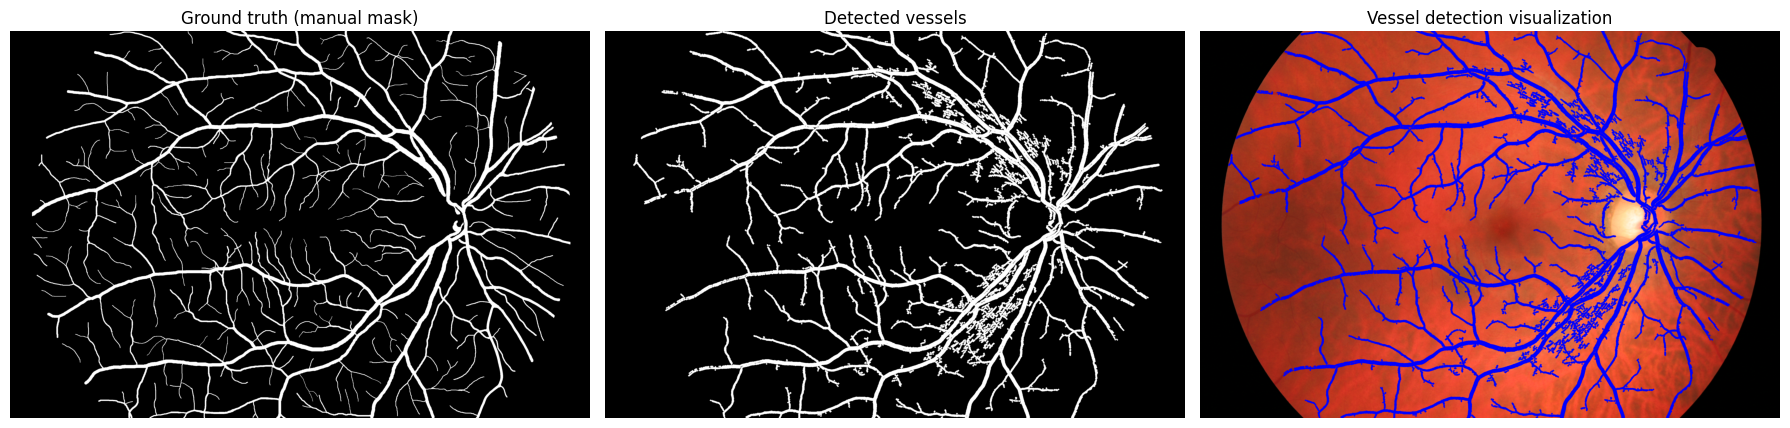

accuracy: 0.9202, sensitivity: 0.8124, specificity: 0.9350, arithmetic mean: 0.8737, geometric mean: 0.8715


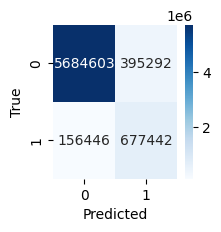

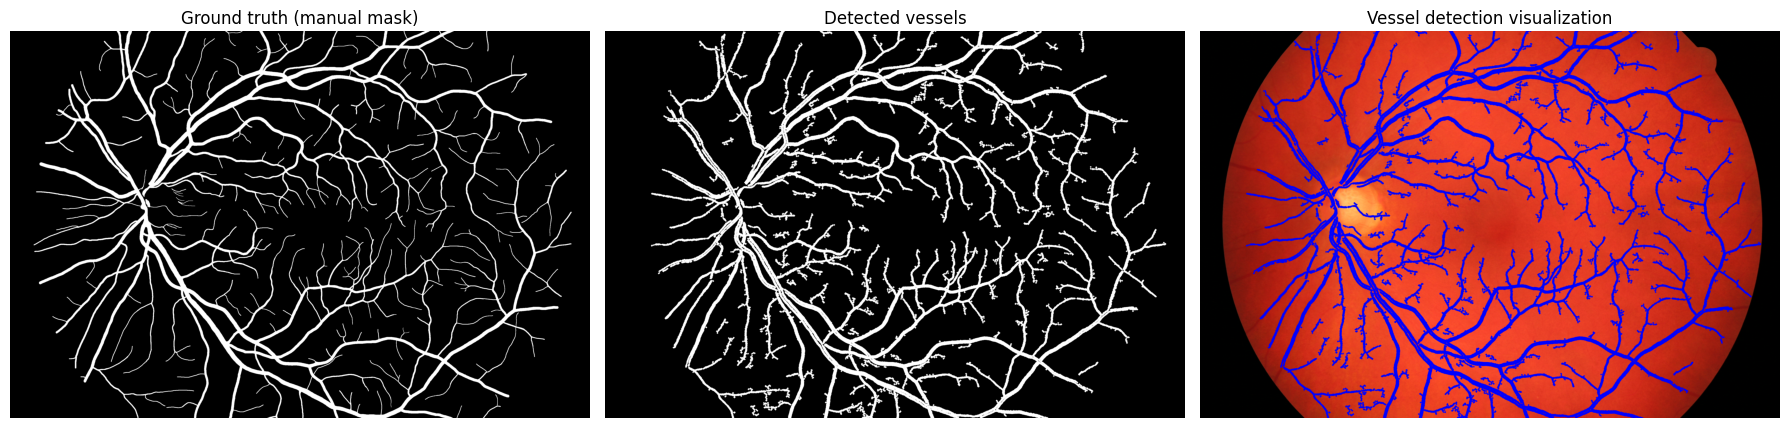

accuracy: 0.9290, sensitivity: 0.8512, specificity: 0.9395, arithmetic mean: 0.8954, geometric mean: 0.8943


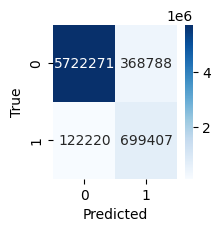

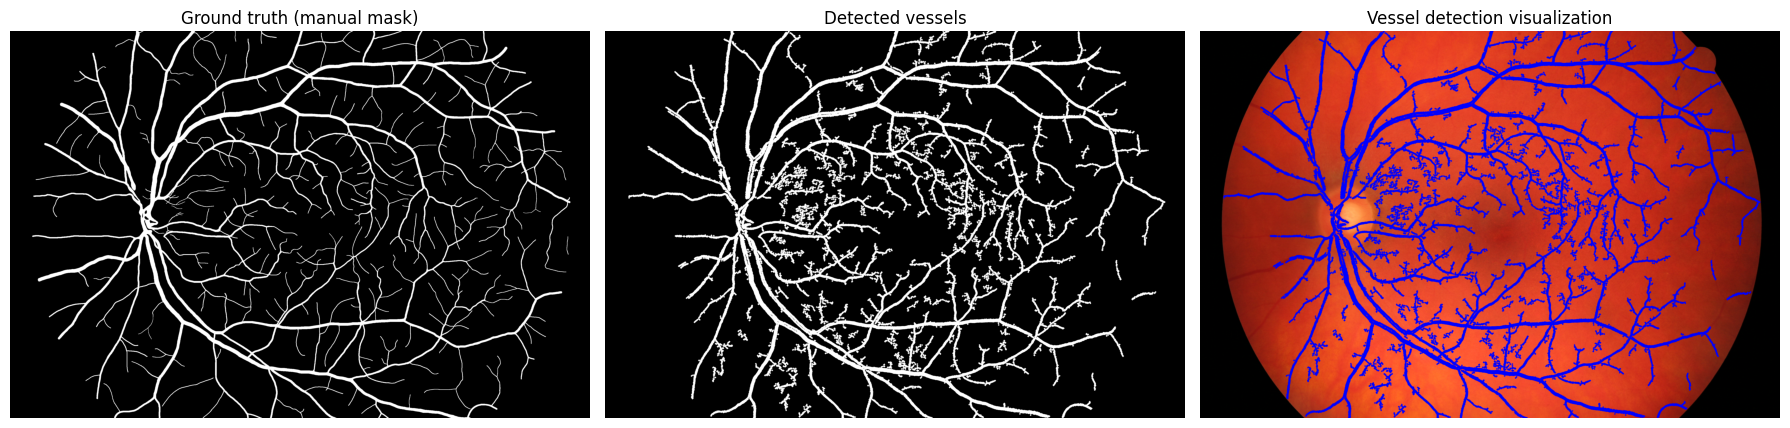

accuracy: 0.9140, sensitivity: 0.8332, specificity: 0.9232, arithmetic mean: 0.8782, geometric mean: 0.8771


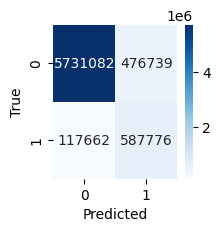

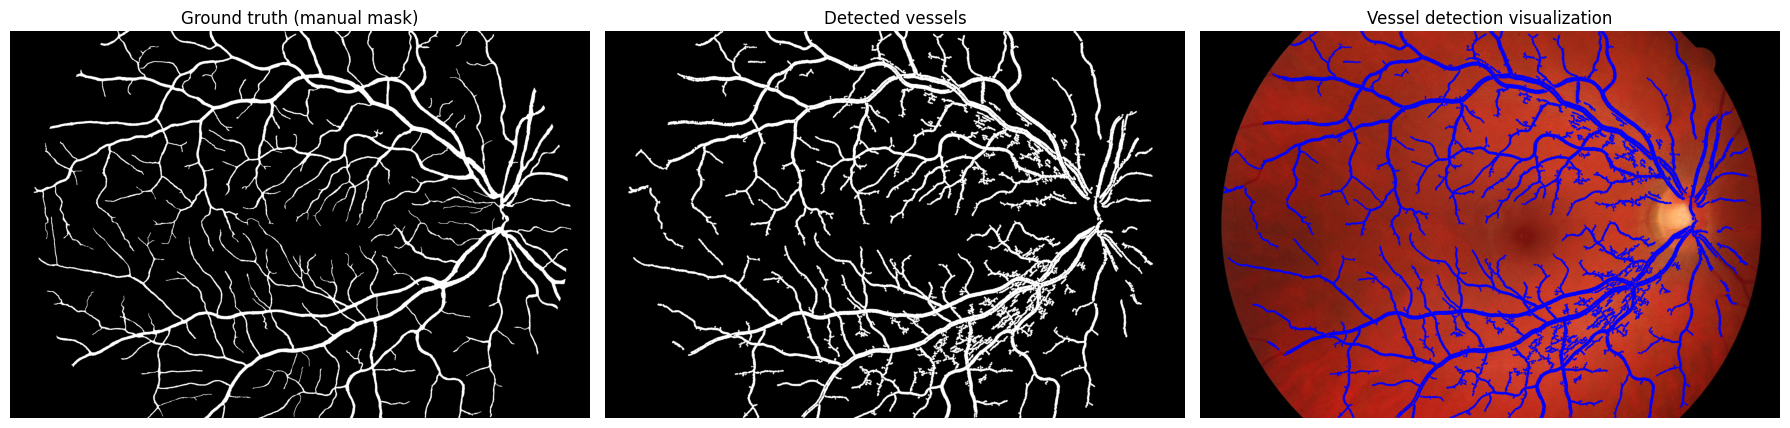

accuracy: 0.9235, sensitivity: 0.8341, specificity: 0.9346, arithmetic mean: 0.8843, geometric mean: 0.8829


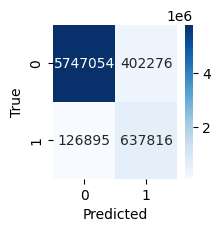

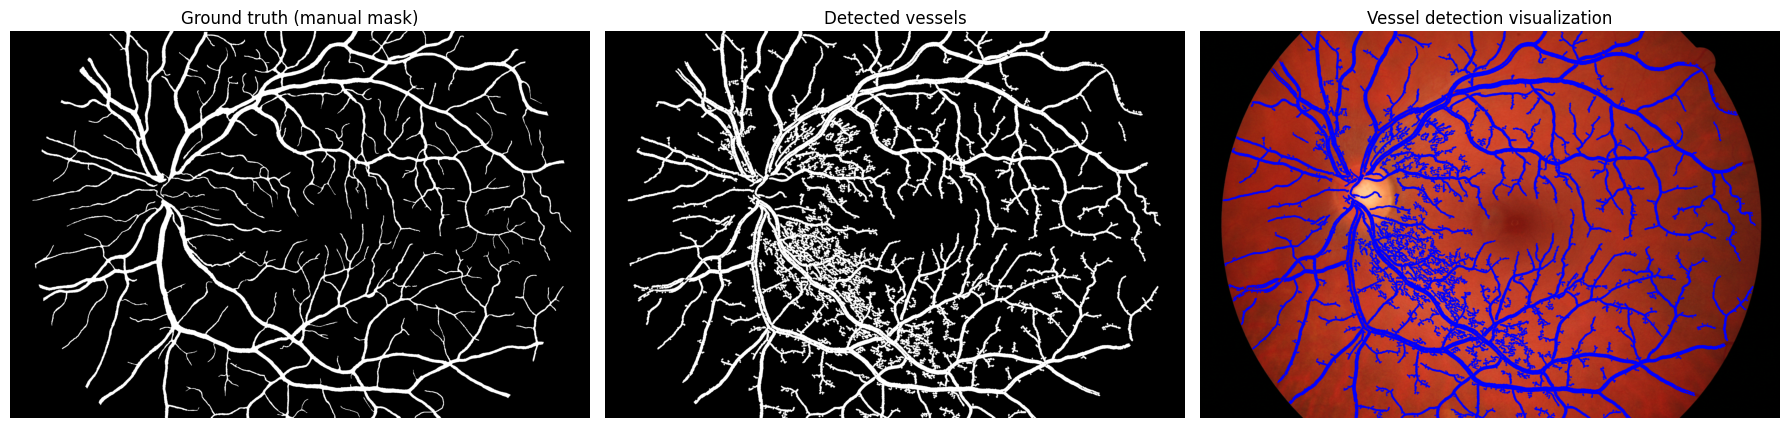

accuracy: 0.8995, sensitivity: 0.9081, specificity: 0.8983, arithmetic mean: 0.9032, geometric mean: 0.9032


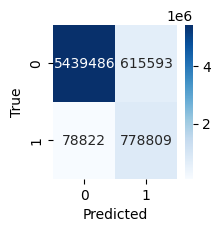

In [ ]:
test_data = ["01_h.jpg", "08_h.jpg", "10_h.jpg", "11_h.jpg", "12_h.jpg"]

for i in test_data:
    img, manual, fov = load_image(i)
    vessels = image_processing(img, fov)
    show_results(img, vessels, manual)
    evaluate_detection(manual, vessels, fov)

### 2. Machine learning classifier

### 3. Deep learning model